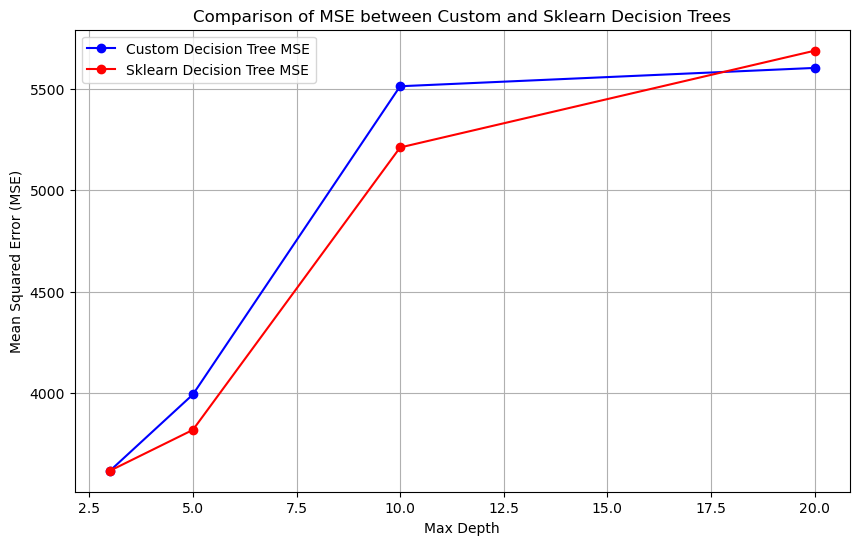

In [13]:
import numpy as np
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import pandas as pd
from sklearn.tree import DecisionTreeRegressor as SklearnDecisionTree
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("https://www4.stat.ncsu.edu/~boos/var.select/diabetes.tab.txt", sep='\t')

# Create target series and feature matrix
y = df['Y']
X = df.loc[:, df.columns != 'Y']

# Split the dataset into training and testing sets (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Convert to numpy arrays for use in custom decision tree model
X_train_np = X_train.values
X_test_np = X_test.values
y_train_np = y_train.values
y_test_np = y_test.values

class DecisionTreeRegressor:
    def __init__(self, min_samples=1, max_depth=3):
        self.min_samples = min_samples  # Minimum number of samples
        self.max_depth = max_depth  # Maximum depth
        self.root = None  # Root node of the decision tree

    class RegressionTree:
        def __init__(self, sequence, depth=0, max_depth=3):
            self.isLeaf = True  # Whether this node is a leaf
            self.left = None  # Left subtree
            self.right = None  # Right subtree
            self.output = None  # Prediction value for the current node
            self.sequence = sequence  # Indices of samples at the current node
            self.parameter = None  # Splitting feature
            self.divide = None  # Splitting point
            self.depth = depth  # Current depth
            self.max_depth = max_depth  # Maximum depth

        # Grow from the current node
        def grow(self, data, result, minnum):
            if len(self.sequence) <= minnum or self.depth >= self.max_depth:  # Stop splitting if sample size is insufficient or maximum depth is reached
                self.output = np.mean(result[self.sequence])  # Set the prediction value as the mean
                return

            # Find the best splitting feature and splitting point
            parameter, divide, err = bestdivide(data, result, self.sequence)
            left = []
            right = []

            # Split data
            for i in self.sequence:
                if data[i, parameter] < divide:
                    left.append(i)
                else:
                    right.append(i)

            # Update node information
            self.parameter = parameter
            self.divide = divide
            self.isLeaf = False
            self.left = DecisionTreeRegressor.RegressionTree(left, depth=self.depth + 1, max_depth=self.max_depth)
            self.right = DecisionTreeRegressor.RegressionTree(right, depth=self.depth + 1, max_depth=self.max_depth)

            # Recursively grow left and right subtrees
            self.left.grow(data, result, minnum)
            self.right.grow(data, result, minnum)

        # Predict a single sample
        def predict_single(self, x):
            if self.isLeaf:  # If this is a leaf node, return the prediction value
                return self.output
            if x[self.parameter] < self.divide:  # If less than the splitting point, go to the left subtree
                return self.left.predict_single(x)
            else:  # Otherwise, go to the right subtree
                return self.right.predict_single(x)

    # Fit the training data
    def fit(self, X, y):
        self.root = self.RegressionTree(sequence=range(len(y)), max_depth=self.max_depth)
        self.root.grow(X, y, self.min_samples)

    # Predict the input data
    def predict(self, X):
        return np.array([self.root.predict_single(sample) for sample in X])

# Calculate the sum of squared errors for the chosen parameter and splitting point
def squaErr(data, result, sequence, parameter, divide):
    left = []
    right = []

    for i in sequence:
        if data[i, parameter] < divide:
            left.append(i)
        else:
            right.append(i)

    if len(left) == 0 or len(right) == 0:  # If either subset is empty, return positive infinity
        return float('inf')

    c1 = np.mean(result[left])
    err1 = np.sum((result[left] - c1) ** 2)

    c2 = np.mean(result[right])
    err2 = np.sum((result[right] - c2) ** 2)

    return err1 + err2

# Determine the next splitting parameter and splitting point by exhaustive search
def bestdivide(data, result, sequence):
    min_para = 0
    sortedValue = np.sort(data[sequence][:, min_para])
    min_divide = (sortedValue[0] + sortedValue[1]) / 2
    err = squaErr(data, result, sequence, min_para, min_divide)

    for para in range(data.shape[1]):
        sortedValue = np.sort(data[sequence][:, para])
        sliceValue = (sortedValue[1:] + sortedValue[:-1]) / 2

        for divide in sliceValue:
            errNew = squaErr(data, result, sequence, para, divide)
            if errNew < err:
                err = errNew
                min_para = para
                min_divide = divide

    return min_para, min_divide, err

max_depths = [3, 5, 10, 20]

# Store MSE results for custom and sklearn models
custom_mse_list = []
sklearn_mse_list = []

# Loop through different max depths and train models
for depth in max_depths:
    # Train custom decision tree
    custom_model = DecisionTreeRegressor(min_samples=2, max_depth=depth)
    custom_model.fit(X_train_np, y_train_np)
    custom_y_pred = custom_model.predict(X_test_np)
    custom_mse = mean_squared_error(y_test_np, custom_y_pred)
    custom_mse_list.append(custom_mse)

    # Train sklearn decision tree
    sklearn_model = SklearnDecisionTree(max_depth=depth, min_samples_split=2, random_state=42)
    sklearn_model.fit(X_train_np, y_train_np)
    sklearn_y_pred = sklearn_model.predict(X_test_np)
    sklearn_mse = mean_squared_error(y_test_np, sklearn_y_pred)
    sklearn_mse_list.append(sklearn_mse)

# Plot the MSE for custom and sklearn decision trees
plt.figure(figsize=(10, 6))
plt.plot(max_depths, custom_mse_list, marker='o', linestyle='-', color='b', label='Custom Decision Tree MSE')
plt.plot(max_depths, sklearn_mse_list, marker='o', linestyle='-', color='r', label='Sklearn Decision Tree MSE')
plt.xlabel('Max Depth')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Comparison of MSE between Custom and Sklearn Decision Trees')
plt.legend()
plt.grid(True)
plt.show()
